# Global air transportation network 

### Network science project

Stefania Lavarda ID: 51008A

## Dataset

I use the **OpenFlights Airport Network** dataset, which provides information on airports worldwide and the direct flight routes connecting them.
- **Nodes** represent airports around the world, as defined in the `airports.dat` file. Each node corresponds to a unique airport and includes metadata such as geographic location (latitude and longitude), city, and country.
- **Directed edges** represent direct flight routes between airports. A directed edge from airport *i* to airport *j* indicates the existence of at least one scheduled direct flight from *i* to *j*, as provided in the `routes.dat` file.
- **Edge attributes** include the operating airline, the number of stops, codeshare information, and the type of aircraft equipment used on the route.
- **Edge weights** are defined as the number of distinct airlines operating a given route from airport *i* to airport *j*. This weighting scheme captures the intensity and competitiveness of connections between airport pairs.

## Global research question

How does the structure of the global air transportation network shape worldwide connectivity, and which airports play the most crucial roles in maintaining efficient international mobility?

I will answer this by:
- Constructing the global air transportation network as a directed weighted graph
- Analyzing basic structural properties of the network
- Identifying critical airports and routes using centrality measures
- Detecting communities 

## Research questions

**Question 1:** How geographically connected is the global air transportation network?  
This question focuses on understanding the overall connectivity of the network, including reachability, density, and path structure.

**Question 2:** What are the main global air transportation hubs and communities?  
This question aims to identify highly influential airports and groups of airports that form densely connected regions within the network.

## 1. Load and explore the dataset

### Research question
What does the global air transportation network look like, and what are its basic structural characteristics?

### Method
We begin by loading the airport and route datasets and constructing a directed network representation. Airports are modeled as nodes, while direct flight routes are modeled as directed edges. The network construction process includes:

- Loading airport (node) and route (edge) data
- Filtering routes to include only direct flights (zero stops)
- Constructing a directed graph
- Attaching relevant node and edge attributes
- Computing basic structural properties, including:
  - Number of nodes and edges
  - Presence of self-loops
  - Presence of multi-edges
  - Sample inspection of nodes and edges

This initial exploration provides a foundational understanding of the scale and structure of the global air transportation network before proceeding to more advanced analyses.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# airports.dat columns
airports_cols = [
    "airport_id", "name", "city", "country", "iata", "icao",
    "latitude", "longitude", "altitude", "timezone", "dst",
    "tz_database_time", "type", "source"
]

In [3]:
# routes.dat columns 
routes_cols = [
    "airline", "airline_id", "source_airport", "source_airport_id",
    "dest_airport", "dest_airport_id", "codeshare", "stops", "equipment"
]

In [4]:
# Load the data
airports = pd.read_csv(
    "data/airports.dat.csv",
    header=None,
    names=airports_cols,
    na_values="\\N"
)

routes = pd.read_csv(
    "data/routes.dat.csv",
    header=None,
    names=routes_cols,
    na_values="\\N"
)

In [5]:
# Check
airports.head()

,airport_id,name,city,country,iata,icao,latitude,longitude,altitude,timezone,dst,tz_database_time,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports


In [45]:
print("NaN in country:", airports["country"].isna().sum())

NaN in country: 0


In [7]:
# Check
routes.head()

,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,codeshare,stops,equipment
0,2B,410.0,AER,2965.0,KZN,2990.0,NaN,0,CR2
1,2B,410.0,ASF,2966.0,KZN,2990.0,NaN,0,CR2
2,2B,410.0,ASF,2966.0,MRV,2962.0,NaN,0,CR2
3,2B,410.0,CEK,2968.0,KZN,2990.0,NaN,0,CR2
4,2B,410.0,CEK,2968.0,OVB,4078.0,NaN,0,CR2


In [8]:
# Basic dataset info (useful in notebook narrative)
print("Airports shape:", airports.shape)
print("Routes shape:", routes.shape)

print("\nMissing airport_id in airports:", airports["airport_id"].isna().sum())
print("Missing source_airport_id in routes:", routes["source_airport_id"].isna().sum())
print("Missing dest_airport_id in routes:", routes["dest_airport_id"].isna().sum())

Airports shape: (7698, 14)
Routes shape: (67663, 9)

Missing airport_id in airports: 0
Missing source_airport_id in routes: 220
Missing dest_airport_id in routes: 221


### Data Cleaning

During the inspection of the routes dataset, I observed a small number of routes with missing source or destination airport identifiers. These missing values correspond to routes referencing airports that are not present in the airport dataset and therefore cannot be mapped to valid nodes in the network.

Since these routes represent less than 1% of the total number of routes, I remove them from the analysis. This ensures that all edges in the network connect valid airport nodes and maintains the interpretability of the graph representation.


In [9]:
# Remove routes with missing source or destination airport IDs
routes = routes.dropna(subset=["source_airport_id", "dest_airport_id"])

print("Routes after cleaning:", routes.shape)

Routes after cleaning: (67240, 9)


I restrict the analysis to routes with zero stops in order to model only direct physical connections between airports. Routes with intermediate stops do not specify the transfer airports and therefore cannot be accurately represented as edges in the network. This choice ensures that network paths correspond to realistic travel itineraries.
Routes with intermediate stops were excluded from the analysis. Although such routes represent valid passenger itineraries, the OpenFlights dataset does not specify the intermediate transfer airports. Including these routes as direct edges would introduce artificial shortcuts and distort path-based network measures. Therefore, only direct routes (stops = 0) were considered, allowing the network to accurately represent the physical topology of the global air transportation system.


In [10]:
routes = routes[routes["stops"] == 0]

### Aggregate routes to compute edge weights

After filtering routes to include only direct flights, I aggregate the data by source and destination airport identifiers. Multiple airlines may operate the same route; therefore, I collapse all such entries into a single directed edge. The weight of each edge is defined as the number of distinct airlines serving that route.

In [ ]:
# Create a table where each row corresponds to one directed edge
edge_weights = (
    routes
    .groupby(["source_airport_id", "dest_airport_id"])["airline"]
    .nunique()
    .reset_index()
    .rename(columns={"airline": "weight"})
)

In [12]:
valid_airports = set(airports["airport_id"].astype(int))

missing = (
    set(edge_weights["source_airport_id"])
    .union(set(edge_weights["dest_airport_id"]))
    - valid_airports
)

print("Airport IDs in routes but missing in airports:", len(missing))

Airport IDs in routes but missing in airports: 112


In [ ]:
# Remove routes whose source or destination airport ID does not appear in the airports dataset
edge_weights = edge_weights[
    edge_weights["source_airport_id"].isin(valid_airports) &
    edge_weights["dest_airport_id"].isin(valid_airports)
]

Some routes in routes.dat reference airport IDs that are not present in the airports.dat dataset.
As a result, these airport IDs cannot be matched to a real airport with known attributes.
To maintain consistency between the route list and the airport metadata, such routes were removed before building the network.

In [14]:
edge_weights.head()

,source_airport_id,dest_airport_id,weight
0,1.0,2.0,1
1,1.0,3.0,1
2,1.0,4.0,1
3,1.0,5.0,2
4,2.0,1.0,1


### 1.1 Build the network

In [15]:
# Create an empty directed graph
G = nx.DiGraph()

In [16]:
print("Airports columns:", airports.columns)

Airports columns: Index(['airport_id', 'name', 'city', 'country', 'iata', 'icao', 'latitude',
       'longitude', 'altitude', 'timezone', 'dst', 'tz_database_time', 'type',
       'source'],
      dtype='object')


In [17]:
print("Routes columns:", routes.columns)

Routes columns: Index(['airline', 'airline_id', 'source_airport', 'source_airport_id',
       'dest_airport', 'dest_airport_id', 'codeshare', 'stops', 'equipment'],
      dtype='object')


In [18]:
print("Edge weights columns:", edge_weights.columns)

Edge weights columns: Index(['source_airport_id', 'dest_airport_id', 'weight'], dtype='object')


In [19]:
# Add airport nodes
for _, row in airports.iterrows():
    G.add_node(
        int(row["airport_id"]),
        name=row["name"],
        city=row["city"],
        country=row["country"],
        iata=row["iata"],
        icao=row["icao"],
        latitude=row["latitude"],
        longitude=row["longitude"],
        altitude=row["altitude"],
        timezone=row["timezone"],
        dst=row["dst"],
        tz_database_time=row["tz_database_time"],
        type=row["type"],
        source=row["source"]
    )

In [20]:
# Add edges with weight = number of distinct airlines
for _, row in edge_weights.iterrows():
    G.add_edge(
        int(row["source_airport_id"]),
        int(row["dest_airport_id"]),
        weight=int(row["weight"])
    )

In [21]:
# Basic metrics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

self_loops = list(nx.selfloop_edges(G))
print(f"Number of self-loops: {len(self_loops)}")

isolates = list(nx.isolates(G))
print(f"Number of isolated nodes: {len(isolates)}")

Number of nodes: 7698
Number of edges: 36907
Number of self-loops: 1
Number of isolated nodes: 4484


Isolated airports (degree 0) are kept in the full network for global descriptive statistics (e.g., density, connected components) because they are part of the dataset and reflect airports with no direct flights in routes.dat after filtering.
However, isolates are removed only for community detection (Louvain), since they have no edges and would trivially form single-node communities without affecting the modular structure.

I detected a single self-loop in the network, corresponding to a route that starts and ends at the same airport. Since such connections have no physical interpretation in air transportation networks, the self-loop was removed from the analysis.

In [22]:
G.remove_edges_from(nx.selfloop_edges(G))

A large number of isolated nodes are present in the network. These correspond to airports listed in the OpenFlights airport database that do not appear in any direct commercial route after filtering for valid identifiers and direct flights. This highlights the strong heterogeneity of the global air transportation system, where a relatively small subset of airports concentrates the majority of connections.

In [23]:
# Check one node and one edge
some_node = list(G.nodes)[0]
print("Example node:", some_node, G.nodes[some_node])

some_edge = list(G.edges)[0]
print("Example edge:", some_edge, G.edges[some_edge])

Example node: 1 {'name': 'Goroka Airport', 'city': 'Goroka', 'country': 'Papua New Guinea', 'iata': 'GKA', 'icao': 'AYGA', 'latitude': -6.081689834590001, 'longitude': 145.391998291, 'altitude': 5282, 'timezone': 10.0, 'dst': 'U', 'tz_database_time': 'Pacific/Port_Moresby', 'type': 'airport', 'source': 'OurAirports'}
Example edge: (1, 2) {'weight': 1}


In [24]:
missing = (
    set(edge_weights["source_airport_id"])
    .union(set(edge_weights["dest_airport_id"]))
    - set(airports["airport_id"])
)

print("Number of edge endpoints missing in nodes:", len(missing))

Number of edge endpoints missing in nodes: 0


### 1.2 Network visualisation

In [25]:
# Check missing latitude / longitude in the airports dataset
# Count missing latitude or longitude
missing_lat = airports["latitude"].isna().sum()
missing_lon = airports["longitude"].isna().sum()

print(f"Airports missing latitude: {missing_lat}")
print(f"Airports missing longitude: {missing_lon}")
print(f"Total airports: {len(airports)}")

Airports missing latitude: 0
Airports missing longitude: 0
Total airports: 7698


In [26]:
# Check airports missing either latitude OR longitude
missing_geo = airports[
    airports["latitude"].isna() | airports["longitude"].isna()
]

print(f"Airports missing latitude OR longitude: {len(missing_geo)}")

Airports missing latitude OR longitude: 0


In [28]:
# Check for impossible latitude / longitude
invalid_coords = airports[
    (airports["latitude"].abs() > 90) |
    (airports["longitude"].abs() > 180)
]

print(f"Airports with invalid coordinates: {len(invalid_coords)}")

Airports with invalid coordinates: 0


### Export nodes and edges csv file for Gephi

In [29]:
# Create nodes dataframe for Gephi
nodes_gephi = airports[[
    "airport_id",
    "name",
    "iata",
    "city",
    "country",
    "latitude",
    "longitude"
]].copy()

# Rename columns to match Gephi conventions
nodes_gephi = nodes_gephi.rename(columns={
    "airport_id": "id",
    "name": "label"
})

# Ensure correct types
nodes_gephi["id"] = nodes_gephi["id"].astype(int)
nodes_gephi["latitude"] = nodes_gephi["latitude"].astype(float)
nodes_gephi["longitude"] = nodes_gephi["longitude"].astype(float)

# Save to CSV
nodes_gephi.to_csv("nodes_gephi.csv", index=False)

print("nodes_gephi.csv created")
print("Number of nodes:", len(nodes_gephi))
nodes_gephi.head()

nodes_gephi.csv created
Number of nodes: 7698


,id,label,iata,city,country,latitude,longitude
0,1,Goroka Airport,GKA,Goroka,Papua New Guinea,-6.081690,145.391998
1,2,Madang Airport,MAG,Madang,Papua New Guinea,-5.207080,145.789001
2,3,Mount Hagen Kagamuga Airport,HGU,Mount Hagen,Papua New Guinea,-5.826790,144.296005
3,4,Nadzab Airport,LAE,Nadzab,Papua New Guinea,-6.569803,146.725977
4,5,Port Moresby Jacksons International Airport,POM,Port Moresby,Papua New Guinea,-9.443380,147.220001


In [30]:
# Create edges dataframe for Gephi
edges_gephi = edge_weights.copy()

edges_gephi = edges_gephi.rename(columns={
    "source_airport_id": "source",
    "dest_airport_id": "target"
})

edges_gephi["source"] = edges_gephi["source"].astype(int)
edges_gephi["target"] = edges_gephi["target"].astype(int)
edges_gephi["weight"] = edges_gephi["weight"].astype(int)

# Explicitly set graph type
edges_gephi["type"] = "Directed"

# Save to CSV
edges_gephi.to_csv("edges_gephi.csv", index=False)

print("edges_gephi.csv created")
print("Number of edges:", len(edges_gephi))
edges_gephi.head()

edges_gephi.csv created
Number of edges: 36907


,source,target,weight,type
0,1,2,1,Directed
1,1,3,1,Directed
2,1,4,1,Directed
3,1,5,2,Directed
4,2,1,1,Directed


![Modularity world map](map_baseline.png)

## 2. Degree Analysis (in-degree, out-degree)
### Research question
How is global air traffic distributed across airports?
Are flight connections spread relatively evenly, or are they concentrated around a small number of major hubs?
### Method
To investigate how connections are distributed in the global air transportation network, I compute the **in-degree** and **out-degree** of each airport in the directed graph:
- **In-degree** represents the number of distinct airports that have direct flights arriving at a given airport.
- **Out-degree** represents the number of distinct airports that can be reached by direct flights departing from a given airport.
Then, I plot the in-degree and out-degree distributions to analyze their shape (uniform vs. highly skewed).
### Why:
Degree distributions provide insight into the structural organization of the network. If most airports have only a few connections while a small number of airports have very many, the network exhibits a **hub-and-spoke structure**, which is characteristic of global aviation systems.

In [31]:
# 2.1 Compute in-degree and out-degree
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Convert to pandas DataFrame for analysis
deg_df = pd.DataFrame({
    "airport_id": list(G.nodes()),
    "in_degree": [in_degrees[n] for n in G.nodes()],
    "out_degree": [out_degrees[n] for n in G.nodes()]
})

# Total degree (in + out)
deg_df["total_degree"] = deg_df["in_degree"] + deg_df["out_degree"]

deg_df = deg_df.merge(
    airports[["airport_id", "name", "city", "country"]],
    on="airport_id",
    how="left"
)

# Inspect the most connected airports
deg_df.sort_values("total_degree", ascending=False).head()

,airport_id,in_degree,out_degree,total_degree,name,city,country
336,340,238,239,477,Frankfurt am Main Airport,Frankfurt,Germany
1346,1382,233,237,470,Charles de Gaulle International Airport,Paris,France
574,580,231,232,463,Amsterdam Airport Schiphol,Amsterdam,Netherlands
1655,1701,227,224,451,Atatürk International Airport,Istanbul,Turkey
3482,3682,216,217,433,Hartsfield Jackson Atlanta International Airport,Atlanta,United States


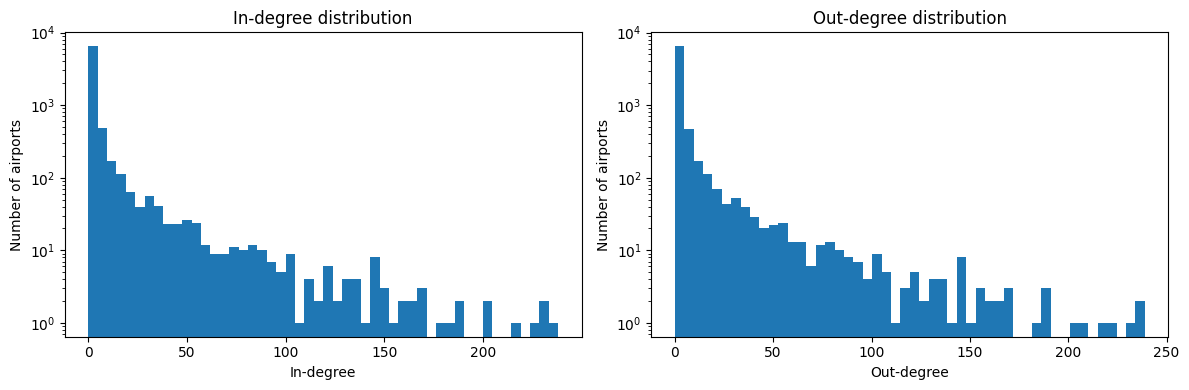

In [32]:
# 2.2 Plot in-degree and out-degree distributions

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(deg_df["in_degree"], bins=50)
axes[0].set_title("In-degree distribution")
axes[0].set_xlabel("In-degree")
axes[0].set_ylabel("Number of airports")
axes[0].set_yscale("log")

axes[1].hist(deg_df["out_degree"], bins=50)
axes[1].set_title("Out-degree distribution")
axes[1].set_xlabel("Out-degree")
axes[1].set_ylabel("Number of airports")
axes[1].set_yscale("log")

plt.tight_layout()
plt.show()

### Comment
The degree distributions are highly skewed, with most airports having only a small number of direct connections and a small number of airports exhibiting very high in-degree and out-degree values. This pattern indicates a pronounced **hub-and-spoke structure** in the global air transportation network, where major hub airports play a crucial role in maintaining global connectivity.

## 3. Network density

### Research question
Is the global air transportation network highly interconnected, or do airlines operate only a small fraction of the possible direct routes between airports?
### Method & why
I compute the **density** of the directed network, defined as:
$$
{density} = \frac{m}{n(n-1)}
$$

where m is the number of directed edges and n is the number of nodes.  
This metric measures the fraction of all possible airport-to-airport connections that are actually present in the network.
### Why:
Network density provides insight into how interconnected the system is overall. A low density indicates that most possible direct connections between airports do not exist, helping explain why certain airports emerge as critical hubs for maintaining global connectivity.

In [33]:
density = nx.density(G)
print(f"Network density: {density:.6f}")

Network density: 0.000623


### Comment
The network density is extremely low (approximately 0.000623), meaning that only about **0.06%** of all possible airport-to-airport connections are realized through direct flights. This highlights the strong sparsity of the global air transportation network.

Airlines operate only a limited subset of feasible routes due to economic, geographic, and operational constraints. Such low density reflects a pronounced **hub-and-spoke structure**, in which most airports rely on a small number of major hubs to reach the rest of the world efficiently.

## 4. Reciprocity

In a directed network, reciprocity measures the fraction of directed edges i→j for which the reverse edge j→i also exists.

### Research Question
To what extent are direct flight connections between airports bidirectional?
### Method
I compute the **global reciprocity** of the directed network, defined as the fraction of directed edges for which the reverse edge also exists. A high reciprocity value indicates that most airport pairs are connected by flights in both directions, while a low value suggests a more asymmetric structure.


In [34]:
# Global reciprocity
global_reciprocity = nx.reciprocity(G)
print(f"Global reciprocity: {global_reciprocity:.4f}")

Global reciprocity: 0.9781


### Comment
The observed reciprocity indicates that a large fraction of direct flight routes are bidirectional, reflecting the operational need for round-trip connections in commercial aviation. However, reciprocity is not equal to one, suggesting the presence of asymmetric routes driven by factors such as uneven travel demand, geographic constraints, or airline-specific operational strategies.

## 5. Connected components

### Research Question

Is the global air transportation network fully connected, or does it break into disconnected groups of airports?  
In particular, are airports globally reachable when ignoring flight direction, and how much mutual reachability exists when respecting direction?

### Method
We compute two types of connected components in the directed airport network:

- **Weakly Connected Components (WCC)**: components computed after ignoring edge direction.  
  Two airports are in the same WCC if there exists *some* path between them when treating routes as undirected.
- **Strongly Connected Components (SCC)**: components computed while respecting edge direction.  
  Two airports are in the same SCC only if they are *mutually reachable* through directed paths.

We then analyze the number of components and the sizes of the largest components.

### Why:

- **Weak connectivity** indicates whether airports belong to a globally connected system when direction is ignored (i.e., whether airports are part of the same “geographical flight network”).
- **Strong connectivity** is stricter and captures whether airports are mutually reachable through directed routes, which is relevant for assessing the existence of round-trip travel opportunities and directed mobility cycles.


In [35]:
# 5.1 Weakly and strongly connected components
wcc = list(nx.weakly_connected_components(G))
scc = list(nx.strongly_connected_components(G))

# 5.2 Sizes (sorted)
wcc_sizes = sorted((len(c) for c in wcc), reverse=True)
scc_sizes = sorted((len(c) for c in scc), reverse=True)

# 5.3 Print summary
print(f"Number of weakly connected components: {len(wcc)}")
print(f"Sizes of the 5 largest WCCs: {wcc_sizes[:5]}")
print(f"Number of strongly connected components: {len(scc)}")
print(f"Sizes of the 5 largest SCCs: {scc_sizes[:5]}")


Number of weakly connected components: 4491
Sizes of the 5 largest WCCs: [3188, 10, 4, 4, 4]
Number of strongly connected components: 4532
Sizes of the 5 largest SCCs: [3147, 10, 4, 4, 4]


### Comment
The directed airport network contains one very large weakly connected component with 3,188 airports, showing that most airports with at least one direct route belong to a single global air transportation system when flight direction is ignored.

Similarly, the largest strongly connected component includes 3,147 airports, indicating that most of these airports are mutually reachable through directed flight paths. This suggests that round-trip travel is possible between the majority of major airports in the network.

The large number of small components is mainly due to isolated or weakly connected airports, highlighting that global air traffic is unevenly distributed and concentrated among a subset of well-connected airports.

## 6. Transitivity (Clustering)

### Research Question
Does the global air transportation network contain locally interconnected groups of airports, where many airports are connected to each other through triangular patterns?

In this context, clustering captures **local redundancy**: if airport A connects to airports B and C, clustering is high when B and C are also directly connected. This can reflect dense regional aviation systems and the availability of alternative direct routes.

### Method
Because standard clustering measures are most commonly defined for **undirected graphs**, I convert the directed airport network into an undirected version and compute:

- **Global clustering coefficient (transitivity)**: fraction of closed triplets (triangles) over all triplets in the network.
- **Average local clustering coefficient**: average of node-level clustering values.
- **Distribution of local clustering**: to observe how clustering varies across airports.

### Why:
Clustering helps quantify the presence of tightly connected local structures. In an air transportation network, high clustering suggests that airports form dense regional groups with multiple direct connections among neighbors, which may increase route flexibility and reduce dependence on a single connection.

In [36]:
# 6.1 Convert to undirected for clustering measures
G_und = G.to_undirected()

# 6.2 Compute global metrics
global_clustering = nx.transitivity(G_und)
avg_local_clustering = nx.average_clustering(G_und)

print(f"Global clustering coefficient (transitivity): {global_clustering:.4f}")
print(f"Average local clustering: {avg_local_clustering:.4f}")

Global clustering coefficient (transitivity): 0.2497
Average local clustering: 0.2053


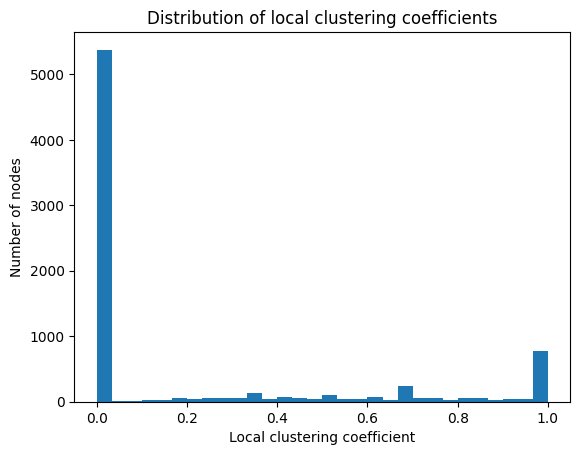

In [37]:
# 6.3 Distribution of local clustering coefficients

clustering_dict = nx.clustering(G_und)
clustering_values = list(clustering_dict.values())

plt.hist(clustering_values, bins=30)
plt.xlabel("Local clustering coefficient")
plt.ylabel("Number of nodes")
plt.title("Distribution of local clustering coefficients")
plt.show()

### Comment
The global clustering coefficient is relatively high (≈ 0.25), indicating that the global air transportation network contains a noticeable number of triangular connections among airports. This suggests that, in some regions, airports are interconnected through multiple alternative direct routes.

However, the distribution of local clustering coefficients shows that most airports have a clustering value close to zero. This means that for the majority of airports, neighboring airports are not directly connected to each other. At the same time, a smaller group of airports exhibits high clustering values, reflecting densely connected regional systems or major aviation areas.

Overall, these results indicate that while the global air network is largely organized around hub-based connections, locally dense structures exist in specific regions of the world.

## 7. Bridges

### Research question
Are there critical flight connections that act as “single links” between different parts of the airport network?  
In other words, which routes are especially important because removing them would break connectivity or make travel between airports less efficient?
### Method & why
- Use the undirected version G_und:
- Compute bridges (edges whose removal disconnects the graph).
- Compute local bridges (edges whose removal increases the shortest-path distance between their endpoints).
### Why:
Bridges highlight routes that are structurally important for keeping parts of the network connected. In an air transportation system, a bridge can represent a connection that links an otherwise separated region (for example, a remote area connected mainly through one airport-route). Removing such an edge could isolate airports or entire regions from the rest of the network.

Local bridges are also important because they represent routes that provide a particularly efficient shortcut between two areas. Even if removing them does not fully disconnect the network, it can increase travel distance (in number of flights), making the network less efficient.

An edge is defined as a bridge if, when it is removed from the graph, it increases the number of connected components.

A local bridge is an edge between two nodes that have neighborhood overlap equals to zero (i.e. when the edge is removed, the shortest path between the two nodes will have length greater than two — no triangles).

An almost local bridge is an edge between two nodes with low neighborhood overlap.

In [38]:
# 7.2 Compute bridges on unidrected graph
bridges = list(nx.bridges(G_und))
print(f"Number of bridges in the undirected graph: {len(bridges)} ({round(len(bridges)/G_und.size()*100,2)}% of edges)")

# Show a few bridges
print("Sample bridges:", bridges[:10])
for u, v in bridges[:10]:
    u_name = G_und.nodes[u].get("name", str(u))
    v_name = G_und.nodes[v].get("name", str(v))
    print(f"{u} ({u_name})  --  {v} ({v_name})")

Number of bridges in the undirected graph: 757 (4.01% of edges)
Sample bridges: [(5, 5420), (5, 5429), (5, 5437), (8, 18), (10, 5446), (11, 18), (12, 18), (15, 18), (31, 178), (54, 145)]
5 (Port Moresby Jacksons International Airport)  --  5420 (Chimbu Airport)
5 (Port Moresby Jacksons International Airport)  --  5429 (Mendi Airport)
5 (Port Moresby Jacksons International Airport)  --  5437 (Wapenamanda Airport)
8 (Godthaab / Nuuk Airport)  --  18 (Reykjavik Airport)
10 (Thule Air Base)  --  5446 (Qaanaaq Airport)
11 (Akureyri Airport)  --  18 (Reykjavik Airport)
12 (Egilsstaðir Airport)  --  18 (Reykjavik Airport)
15 (Ísafjörður Airport)  --  18 (Reykjavik Airport)
31 (Brandon Municipal Airport)  --  178 (Calgary International Airport)
54 (Inuvik Mike Zubko Airport)  --  145 (Tuktoyaktuk Airport)


In [39]:
# 7.3 Compute local bridges on unidrected graph
local_bridges = list(nx.local_bridges(G_und, with_span = False))
print(f"Number of local bridges in the undirected graph: {len(local_bridges)} - ({round(len(local_bridges)/G_und.size()*100,2)}% of edges)")

# Show a few local bridges
print("Sample local bridges:", local_bridges[:10])
for u, v in local_bridges[:10]:
    u_name = G_und.nodes[u].get("name", str(u))
    v_name = G_und.nodes[v].get("name", str(v))
    print(f"{u} ({u_name})  --  {v} ({v_name})")

Number of local bridges in the undirected graph: 1170 - (6.2% of edges)
Sample local bridges: [(5, 5420), (5, 5429), (5, 5437), (8, 16), (8, 18), (9, 609), (10, 5446), (11, 18), (12, 18), (15, 18)]
5 (Port Moresby Jacksons International Airport)  --  5420 (Chimbu Airport)
5 (Port Moresby Jacksons International Airport)  --  5429 (Mendi Airport)
5 (Port Moresby Jacksons International Airport)  --  5437 (Wapenamanda Airport)
8 (Godthaab / Nuuk Airport)  --  16 (Keflavik International Airport)
8 (Godthaab / Nuuk Airport)  --  18 (Reykjavik Airport)
9 (Kangerlussuaq Airport)  --  609 (Copenhagen Kastrup Airport)
10 (Thule Air Base)  --  5446 (Qaanaaq Airport)
11 (Akureyri Airport)  --  18 (Reykjavik Airport)
12 (Egilsstaðir Airport)  --  18 (Reykjavik Airport)
15 (Ísafjörður Airport)  --  18 (Reykjavik Airport)


### Comment
The analysis identifies 757 bridges, corresponding to about 4% of all edges in the undirected network. These routes are structurally important because removing any of them would disconnect part of the network, potentially isolating airports or small regions from the rest of the system.

In addition, 1,170 local bridges are detected, representing about 6% of all edges. Although removing a local bridge does not fully disconnect the network, it increases the distance between airports, making travel less efficient.

Overall, these results show that while the global air transportation network is robust at a large scale, a non-negligible number of routes play a crucial role in maintaining connectivity and efficiency, especially for peripheral or less-connected airports.


## 8. Assortativity

### Research Questions
1. **Degree assortativity:** Do highly connected airports tend to connect to other highly connected airports, or do major hubs mostly connect to many smaller airports?
2. **Country assortativity:** Do airports tend to connect more often to airports in the same country, or are routes mostly international?

### Method
We compute:
- **Degree assortativity coefficient** on the undirected version of the network (`G_und`).  
  This measures whether nodes tend to connect to other nodes with similar degree.
- **Attribute assortativity coefficient** by **country** (a node attribute from `airports.dat`).  
  This measures whether edges tend to connect airports with the same country label.

### Why:
- **Degree assortativity** helps characterize the network structure. A negative value suggests a hub-and-spoke pattern (hubs connected to many low-degree airports), while a positive value suggests hubs tend to connect to hubs.
- **Country assortativity** measures geographic/administrative homophily: if it is high, routes are mostly domestic; if it is low, the network is dominated by international connections.

In [40]:
# 8.1 Degree assortativity
deg_assort = nx.degree_assortativity_coefficient(G_und)
print(f"Degree assortativity coefficient (undirected): {deg_assort:.4f}")

Degree assortativity coefficient (undirected): -0.0167


In [ ]:
# 8.2 Country assortativity (homophily by country)

# Check missing country labels 
countries = nx.get_node_attributes(G, "country")
missing_country = set(G.nodes()) - set(countries.keys())
print(f"Nodes missing country label: {len(missing_country)}")

# Attribute assortativity by country (computed on the undirected graph)
country_assort = nx.attribute_assortativity_coefficient(G_und, "country")
print(f"Country assortativity coefficient: {country_assort:.4f}")

Nodes missing country label: 0
Country assortativity coefficient: 0.4448


### Comment 
The degree assortativity coefficient is slightly negative (−0.017), indicating that highly connected airports do not preferentially connect to other highly connected airports. Instead, major hubs tend to connect with many smaller airports, which is consistent with a hub-and-spoke organization of air transportation.

In contrast, the country assortativity coefficient is relatively high (0.44), showing that airports are much more likely to connect to other airports within the same country than to airports in different countries. This reflects the importance of domestic flight networks and national airline operations in shaping global air traffic patterns.


## 9. Centrality Measures
### Research Question
Which airports are structurally the most important in the global air transportation network?

### Method
To identify airports that play different strategic roles in the network, we compute several centrality measures on the airport graph:

- **Degree centrality**: identifies airports with many direct connections, corresponding to highly active or well-connected hubs.
- **Betweenness centrality**: identifies airports that lie on many shortest paths between other airports, acting as key transfer points or bridges between different parts of the network.
- **Closeness centrality**: identifies airports that can reach other airports with relatively few steps, reflecting overall accessibility within the network.
- **PageRank**: highlights airports that are connected to other important airports, capturing influence beyond simple connectivity.

### Why Centrality Measures?
Different centrality measures capture different roles played by airports in the air transportation system. Some airports act as major hubs with many direct connections, others are crucial for connecting distant regions, and some are globally well-positioned even without having the largest number of routes. Using multiple centrality measures provides a more complete picture of airport importance in maintaining efficient global mobility.


Degree centrality

In [42]:
# 9.1 Degree centrality (on directed, but I can use total degree via undirected)
deg_cent = nx.degree_centrality(G_und)

Betweeness centrality

A node is central if it's in between of most of the shortest paths

In [43]:
# 9.2 Betweenness centrality (can be expensive; run on undirected)
bet_cent = nx.betweenness_centrality(G_und, normalized=True)

Closeness centrality

A node is more central if it can reach all the other nodes faster (shorter path)

In [44]:
# 9.3 Closeness centrality (undirected for reachability)
clo_cent = nx.closeness_centrality(G_und)

PageRank

PageRank highlights airports that are not only well connected, but connected to other important hubs, capturing global influence rather than local connectivity.

PageRank (weighted, directed): PageRank models a random traveler moving along directed flight routes. In the weighted version used here, transitions are biased toward routes served by more distinct airlines (higher edge weight). Therefore, airports receive higher PageRank if they are reached from other high-importance airports, especially through routes with many airlines, capturing global influence beyond simple degree.

In [45]:
# 9.4 PageRank (directed, based on random walks)
pr = nx.pagerank(G, alpha=0.85, weight="weight")

In [46]:
centrality_df = pd.DataFrame({
    "airport_id": list(G.nodes()),
    "name": [G.nodes[n].get("name") for n in G.nodes()],
    "iata": [G.nodes[n].get("iata") for n in G.nodes()],
    "country": [G.nodes[n].get("country") for n in G.nodes()],
    "degree_centrality": [deg_cent[n] for n in G.nodes()],
    "betweenness_centrality": [bet_cent[n] for n in G.nodes()],
    "closeness_centrality": [clo_cent[n] for n in G.nodes()],
    "pagerank": [pr[n] for n in G.nodes()]
})

centrality_df.sort_values("degree_centrality", ascending=False).reset_index(drop=True).head(10)

,airport_id,name,iata,country,degree_centrality,betweenness_centrality,closeness_centrality,pagerank
0,580,Amsterdam Airport Schiphol,AMS,Netherlands,0.032220,0.008896,0.167760,0.003508
1,340,Frankfurt am Main Airport,FRA,Germany,0.031701,0.009135,0.171533,0.003815
2,1382,Charles de Gaulle International Airport,CDG,France,0.031181,0.011074,0.170447,0.004194
3,1701,Atatürk International Airport,ISL,Turkey,0.030272,0.007392,0.162153,0.003422
4,3682,Hartsfield Jackson Atlanta International Airport,ATL,United States,0.028193,0.005206,0.155724,0.007922
5,3830,Chicago O'Hare International Airport,ORD,United States,0.026764,0.008116,0.161084,0.005000
6,3364,Beijing Capital International Airport,PEK,China,0.026634,0.008674,0.161064,0.003975
7,346,Munich Airport,MUC,Germany,0.024945,0.002830,0.161597,0.002613
8,3670,Dallas Fort Worth International Airport,DFW,United States,0.024425,0.005208,0.155981,0.004604
9,4029,Domodedovo International Airport,DME,Russia,0.024425,0.005170,0.145555,0.003693


In [47]:
# 9.5 Show top nodes by different centralities

def show_top(df, col, k=10):
    print(f"\nTop {k} airports by {col}:")
    display(
        df.sort_values(col, ascending=False)
          .reset_index(drop=True)
          .head(k)[["airport_id", "name", "iata", "country", col]]
    )

show_top(centrality_df, "degree_centrality")
show_top(centrality_df, "betweenness_centrality")
show_top(centrality_df, "closeness_centrality")
show_top(centrality_df, "pagerank")


Top 10 airports by degree_centrality:


,airport_id,name,iata,country,degree_centrality
0,580,Amsterdam Airport Schiphol,AMS,Netherlands,0.032220
1,340,Frankfurt am Main Airport,FRA,Germany,0.031701
2,1382,Charles de Gaulle International Airport,CDG,France,0.031181
3,1701,Atatürk International Airport,ISL,Turkey,0.030272
4,3682,Hartsfield Jackson Atlanta International Airport,ATL,United States,0.028193
5,3830,Chicago O'Hare International Airport,ORD,United States,0.026764
6,3364,Beijing Capital International Airport,PEK,China,0.026634
7,346,Munich Airport,MUC,Germany,0.024945
8,3670,Dallas Fort Worth International Airport,DFW,United States,0.024425
9,4029,Domodedovo International Airport,DME,Russia,0.024425



Top 10 airports by betweenness_centrality:


,airport_id,name,iata,country,betweenness_centrality
0,1382,Charles de Gaulle International Airport,CDG,France,0.011074
1,3484,Los Angeles International Airport,LAX,United States,0.010541
2,3774,Ted Stevens Anchorage International Airport,ANC,United States,0.010179
3,2188,Dubai International Airport,DXB,United Arab Emirates,0.009653
4,340,Frankfurt am Main Airport,FRA,Germany,0.009135
5,580,Amsterdam Airport Schiphol,AMS,Netherlands,0.008896
6,3364,Beijing Capital International Airport,PEK,China,0.008674
7,3830,Chicago O'Hare International Airport,ORD,United States,0.008116
8,193,Lester B. Pearson International Airport,YYZ,Canada,0.007726
9,1701,Atatürk International Airport,ISL,Turkey,0.007392



Top 10 airports by closeness_centrality:


,airport_id,name,iata,country,closeness_centrality
0,340,Frankfurt am Main Airport,FRA,Germany,0.171533
1,1382,Charles de Gaulle International Airport,CDG,France,0.170447
2,507,London Heathrow Airport,LHR,United Kingdom,0.169375
3,580,Amsterdam Airport Schiphol,AMS,Netherlands,0.167760
4,2188,Dubai International Airport,DXB,United Arab Emirates,0.167144
5,3484,Los Angeles International Airport,LAX,United States,0.164785
6,3797,John F Kennedy International Airport,JFK,United States,0.164580
7,193,Lester B. Pearson International Airport,YYZ,Canada,0.162633
8,1701,Atatürk International Airport,ISL,Turkey,0.162153
9,346,Munich Airport,MUC,Germany,0.161597



Top 10 airports by pagerank:


,airport_id,name,iata,country,pagerank
0,3682,Hartsfield Jackson Atlanta International Airport,ATL,United States,0.007922
1,3830,Chicago O'Hare International Airport,ORD,United States,0.005000
2,3484,Los Angeles International Airport,LAX,United States,0.004828
3,3670,Dallas Fort Worth International Airport,DFW,United States,0.004604
4,1382,Charles de Gaulle International Airport,CDG,France,0.004194
5,507,London Heathrow Airport,LHR,United Kingdom,0.004175
6,3316,Singapore Changi Airport,SIN,Singapore,0.004149
7,3751,Denver International Airport,DEN,United States,0.004031
8,3364,Beijing Capital International Airport,PEK,China,0.003975
9,340,Frankfurt am Main Airport,FRA,Germany,0.003815


### Comment


## 10. Community Detection and Comparison with Groung Truth

### Research Question
Do communities detected from the global air transportation network reflect geographic structure (for example, countries or regions)?  
In other words, are airports grouped into communities that mostly correspond to geographic proximity and domestic flight systems, or are communities strongly mixed due to international hubs?

### Method
We perform community detection on the **undirected** version of the network (`G_und`) to identify groups of airports that are more densely connected to each other than to the rest of the network.

- **Community detection:** we use the **Louvain method** to find communities.
- **Comparison with country labels**:  We compare detected communities with country labels using **Normalized Mutual Information (NMI)**.

### Why:
- Community detection reveals the **mesoscopic structure** of the network: clusters of airports that form strongly connected groups.
- Comparing communities with geographic labels helps interpret what drives connectivity:
  - If communities align well with **country**, this suggests that domestic flight networks and national boundaries strongly shape connectivity.
  - If alignment is low, this suggests that airports are grouped by broader international patterns (e.g., continental structure) and that large hubs create cross-country mixing.

This analysis helps connect network structure to real-world geographic organization of global aviation.

In [48]:
import community as community_louvain

In [49]:
HAVE_NX_LOUVAIN = False
HAVE_COMMUNITY_LOUVAIN = False
HAVE_SKLEARN = False

try:
    from networkx.algorithms.community import louvain_communities
    HAVE_NX_LOUVAIN = True
except Exception:
    HAVE_NX_LOUVAIN = False

try:
    import community as community_louvain  # python-louvain
    HAVE_COMMUNITY_LOUVAIN = True
except Exception:
    HAVE_COMMUNITY_LOUVAIN = False

try:
    from sklearn.metrics import normalized_mutual_info_score
    HAVE_SKLEARN = True
except Exception:
    HAVE_SKLEARN = False

In [50]:
# 10.0 I remove isolates for community detection
G_comm = G_und.copy()
G_comm.remove_nodes_from(list(nx.isolates(G_comm)))

print("G_und nodes/edges:", G_und.number_of_nodes(), G_und.number_of_edges())
print("G_comm nodes/edges (no isolates):", G_comm.number_of_nodes(), G_comm.number_of_edges())

G_und nodes/edges: 7698 18858
G_comm nodes/edges (no isolates): 3214 18858


In [51]:
if HAVE_NX_LOUVAIN:
    print("Using NetworkX's louvain_communities...")
    louvain_comms = louvain_communities(G_comm, seed=42)
elif HAVE_COMMUNITY_LOUVAIN:
    print("Using python-louvain (community_louvain)...")
    partition = community_louvain.best_partition(G_comm, random_state=42)
    # Convert partition dict {node: community_id} to list of sets
    comm_dict = {}
    for node, cid in partition.items():
        comm_dict.setdefault(cid, set()).add(node)
    louvain_comms = list(comm_dict.values())
else:
    print("No Louvain implementation found. Please install 'python-louvain' or upgrade NetworkX.")
    louvain_comms = []

print(f"Detected {len(louvain_comms)} communities.")

Using NetworkX's louvain_communities...
Detected 23 communities.


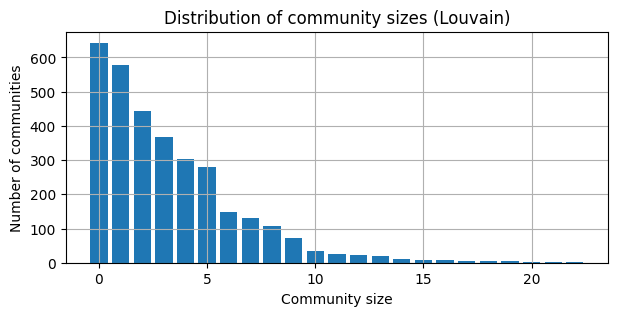

Number of communities: 23
Smallest community: 2 nodes
Largest community: 643 nodes


In [52]:
# Compute community sizes
community_sizes = sorted([len(c) for c in louvain_comms], reverse = True)

# Plot histogram
plt.figure(figsize=(7,3))
plt.bar(range(len(community_sizes)),community_sizes)
plt.xlabel("Community size")
plt.ylabel("Number of communities")
plt.title("Distribution of community sizes (Louvain)")
plt.grid(True)
plt.show()

# Print summary stats
print(f"Number of communities: {len(community_sizes)}")
print(f"Smallest community: {min(community_sizes)} nodes")
print(f"Largest community: {max(community_sizes)} nodes")

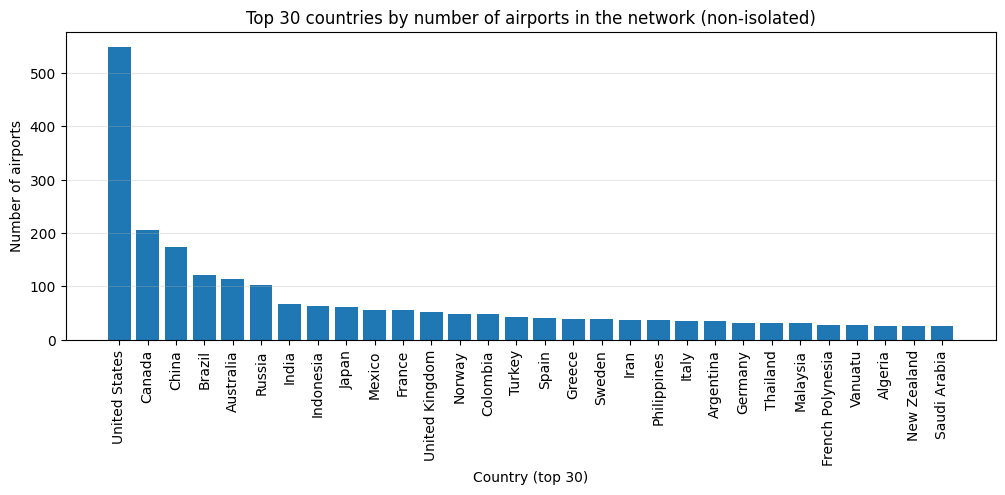

In [53]:
# Count nodes per country (only for nodes in G_comm, to match what Louvain saw)
countries_comm = {n: countries.get(n, None) for n in G_comm.nodes()}
countries_comm = {n: c for n, c in countries_comm.items() if c is not None}

country_sizes = pd.Series(countries_comm).value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 4))
plt.bar(country_sizes.index.astype(str)[:30], country_sizes.values[:30])
plt.xticks(rotation=90)
plt.xlabel("Country (top 30)")
plt.ylabel("Number of airports")
plt.title("Top 30 countries by number of airports in the network (non-isolated)")
plt.grid(axis="y", alpha=0.3)
plt.show()

In [54]:
print(f"Number of countries (non-isolated, with label): {len(country_sizes)}")
print(f"Smallest country group: {country_sizes.min()} airports")
print(f"Largest country group: {country_sizes.max()} airports")

Number of countries (non-isolated, with label): 225
Smallest country group: 1 airports
Largest country group: 549 airports


In [55]:
# 10.2 Compute NMI (country vs community)
if louvain_comms and HAVE_SKLEARN:
    # Map node -> community id
    comm_id_by_node = {}
    for cid, comm in enumerate(louvain_comms):
        for n in comm:
            comm_id_by_node[n] = cid

    # Compare only nodes that are in G_comm (used in Louvain)
    nodes_eval = list(G_comm.nodes())

    true_labels = [countries[n] for n in nodes_eval]               # country
    pred_labels = [comm_id_by_node[n] for n in nodes_eval]         # community id 

    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    print(f"Normalized Mutual Information (NMI) country vs Louvain: {nmi:.4f}")
else:
    print("Cannot compute NMI: missing communities or sklearn.")


Normalized Mutual Information (NMI) country vs Louvain: 0.6446


### Comment
The Normalized Mutual Information (NMI) between the detected communities and country labels is relatively high (0.645), indicating a strong alignment between network-based communities and national boundaries. This suggests that airports tend to be more densely connected within the same country, and that domestic flight networks play an important role in shaping the community structure.

At the same time, the NMI is not equal to one, meaning that communities do not perfectly coincide with countries. This reflects the influence of international hubs and cross-border connections, especially in regions such as Europe, where air transportation is highly integrated across countries.


![Modularity world map](map_modularity.png)

### Comment
The detected communities show a strong geographic structure. Airports within the same region tend to belong to the same community, reflecting dense regional flight networks. For example, most European airports form a single large community, consistent with high connectivity and integration across countries. North America and South America also appear as distinct communities, reflecting strong domestic and regional airline operations.

East Asia forms its own community, while Africa appears more fragmented, reflecting lower route density and reliance on fewer hubs. Overall, the spatial distribution of communities aligns well with real-world aviation patterns, showing that community structure in the network is largely driven by geography, regional demand, and airline operating strategies.

## Overall Synthesis

The global air transportation network reveals a highly structured yet heterogeneous system shaped by geographic, economic, and operational constraints.

**1. Strong global connectivity with limited direct links**
The presence of a giant connected component and high reciprocity shows that most active airports belong to a globally reachable system. However, extremely low network density indicates that airlines operate only a small fraction of all possible routes, relying on indirect connections.

**2. Hub-dominated organization**  
Degree and centrality analyses highlight a small number of major airports as highly connected hubs. These airports play a key role in maintaining global accessibility, while most airports have relatively few direct connections, reflecting a hub-and-spoke structure.

**3. Regional structure and critical routes**  
Clustering and community detection reveal the existence of dense regional subnetworks, such as those in Europe, North America, and East Asia. At the same time, bridge and local bridge analysis identifies specific routes that are essential for connecting regions and maintaining efficient travel paths.

**4. Geographic influence with international integration**  
Community detection results align strongly with geographic and national boundaries, as confirmed by a relatively high NMI with country labels. Nonetheless, communities do not perfectly match countries, highlighting the role of international hubs and cross-border connectivity in shaping global air traffic.

Overall, the network structure reflects a balance between regional organization and global integration, where geographic proximity and national systems guide connectivity, while major hubs enable efficient worldwide mobility.

## 11. Machine Learning on the Network: Predicting Airport Importance

### Machine Learning Task

I define a **node classification problem** on the airport network.  
The goal is to predict whether an airport plays a structurally important role in the network, based on its position and connections.

Specifically, I aim to predict **high betweenness centrality airports** using learned node representations, without explicitly using the betweenness algorithm itself.

### Method

1. **Label definition**  
   Airports are labeled as *high betweenness* or *low betweenness* based on a threshold (e.g., top 10% of betweenness values).

2. **Node embeddings**  
   We use **Node2Vec**, a graph embedding method inspired by Word2Vec, to learn low-dimensional vector representations of airports based on network structure.

3. **Classifier**  
   A supervised machine learning model (e.g., Logistic Regression or Random Forest) is trained to predict the betweenness label from the learned embeddings.

4. **Evaluation**  
   The dataset is split into training and test sets. Performance is evaluated using accuracy and ROC AUC.

### Why:

Betweenness centrality is a global metric that is costly to compute and requires full knowledge of the network. By using node embeddings and machine learning, we test whether structural importance can be inferred from local connectivity patterns alone.

This approach illustrates how graph machine learning can approximate complex network properties using learned representations, which is relevant for large or evolving real-world networks such as air transportation systems.
